# Free Text Analysis

Here we provide a little summary of our key free-text survey responses! There are more advances methods of open-ended NLP (e.g., more advanced contextual POS tagging).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.viz.plot_config import *
from src.utils.helper_funcs import find_project_root
from src.utils.data_loader import load_data, unnest_columns
import tiktoken

enc = tiktoken.encoding_for_model("gpt-4")

### Special text utils
from collections import Counter
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
import string
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

stop_words = set(stopwords.words("english"))
stop_words.update(string.punctuation)

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)


# Set data path
PROJECT_ROOT = find_project_root()


# Load data
data_dict = load_data(PROJECT_ROOT)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hannahrosekirk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hannahrosekirk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/hannahrosekirk/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Load question text
question_mapping = pd.read_json(
    PROJECT_ROOT / "data" / "storage" / "mappings" / "survey_question_mapping.json"
).T

# Turn into a dict
question_mapping = question_mapping.to_dict()["full_question"]

## Utils

In [3]:
# Get only adjective pos tags
def get_adjectives(text):
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    adjectives = [word for word, pos in pos_tags if pos in ["JJ"]]
    return list(set(adjectives))


# Find example windows around top adjectives
def find_windows(text, top_adjectives, window_size=5):
    tokens = word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    windows = []
    for i, (word, pos) in enumerate(pos_tags):
        if word in top_adjectives and pos in [
            "JJ",
            "JJR" and "JJS",
        ]:  # Only consider top adjectives
            start = max(0, i - window_size)
            end = min(len(tokens), i + window_size + 1)
            window = " ".join(tokens[start:end])
            windows.append((word, window))
    return windows


# Find top n-grams
def get_ngrams(text, n=1, remove_stopwords=False):
    # make lower
    text = text.lower()
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Remove stopwords
    if remove_stopwords:
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)
    tokens = word_tokenize(text)
    ngrams = [tuple(tokens[i : i + n]) for i in range(len(tokens) - n + 1)]
    return ngrams

In [4]:
def run_free_text_analysis(df, col, question_text, exclusions=None):
    # Inspect length
    df[f"{col}_chars"] = df[col].apply(lambda x: len(x))
    df[f"{col}_words"] = df[col].apply(lambda x: len(x.split(" ")))

    # Get unique BPE tokens
    tokens = [enc.encode(x) for x in df[col].to_list()]
    tokens = [item for sublist in tokens for item in sublist]
    nunique_tokens = len(list(set(tokens)))

    # Get unique words
    nunique_words = len(list(set(" ".join(df[col].to_list()).split(" "))))

    # Word summary
    word_stats = df[f"{col}_words"].describe()

    # Add the unique counts
    word_stats["nunique_tokens"] = nunique_tokens
    word_stats["nunique_words"] = nunique_words
    print(word_stats)

    # Plot n words
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(df[f"{col}_words"], bins=50, ax=ax)
    ax.set_xlabel("Number of words")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of number of words in system strings")
    plt.tight_layout()
    plt.show()

    # Inspect min and max
    print("MIN ID = ", df[f"{col}_words"].idxmin())
    print(df.loc[df[f"{col}_words"].idxmin()][col])
    # For max print first 100 words
    max = df.loc[df[f"{col}_words"].idxmax()][col]
    max_string = " ".join(max.split(" ")[:100])
    print("MAX ID = ", df[f"{col}_words"].idxmax())
    print(
        f'{max_string}... (truncated at 100 words, another {len(max.split(" ")) - 100} words remaining)'
    )

    #### ADJECTIVES ####
    df[f"{col}_adjectives"] = df[col].apply(get_adjectives)
    all_adjectives = df[f"{col}_adjectives"].explode().dropna()

    ## Get base line adjectives from question text (we want to remove these)
    baseline_adjectives = get_adjectives(question_text)
    # Add manual exclusions
    if exclusions:
        baseline_adjectives.extend(exclusions)
    print(f"Originally {len(all_adjectives)} adjectives")
    all_adjectives = all_adjectives[~all_adjectives.isin(baseline_adjectives)]
    print(
        f"After removing question adjectives and exclusions, {len(all_adjectives)} adjectives remain."
    )

    # Get top adjectives
    top_adjectives = all_adjectives.value_counts().head(20).index.tolist()
    values = all_adjectives.value_counts().head(20).values
    print(top_adjectives)

    # Apply find_windows function with top_adjectives list
    df["windows"] = df[col].apply(lambda text: find_windows(text, top_adjectives))

    examples = {adj: [] for adj in top_adjectives}
    for _, row in df.iterrows():
        for word, window in row["windows"]:
            if len(examples[word]) > 3:  # Only store up to 3 examples
                examples[word].append(window)

    # Get example windows
    examples = {adj: [] for adj in top_adjectives}

    for _, row in df.iterrows():
        for word, window in row["windows"]:
            if len(examples[word]) < 3:  # Only store up to 3 examples
                examples[word].append(window)

    # Set up dict
    adjective_df = {"Adjective": [], "Freq": [], "Example Windows": []}

    for adj, windows in examples.items():
        adjective_df["Adjective"].append(adj)
        # Concatenate up to 3 examples with the specified strings
        concatenated_windows = " | ".join(
            [f"``...{win}...''" for i, win in enumerate(windows)]
        )
        # Replace the adj itself in \textit{} for latex formatting
        concatenated_windows = concatenated_windows.replace(adj, f"\\textit{{{adj}}}")
        adjective_df["Example Windows"].append(concatenated_windows)
        # Get the value
        adjective_df["Freq"].append(len(all_adjectives[all_adjectives == adj]))

    # Create the final DataFrame
    top_adjective_df = pd.DataFrame(adjective_df)
    display(top_adjective_df)

    ### NGRAMS
    df[f"{col}_unigrams"] = df[col].apply(get_ngrams, n=1, remove_stopwords=True)
    df[f"{col}_bigrams"] = df[col].apply(get_ngrams, n=2)
    df[f"{col}_trigrams"] = df[col].apply(get_ngrams, n=3)

    # Get a table of unigrams, bigrams, and trigrams
    n = 10
    frames = []
    for ngram in ["unigrams", "bigrams", "trigrams"]:
        top_ngrams = df[f"{col}_{ngram}"].explode().value_counts().head(n)
        top_ngrams = top_ngrams.reset_index()
        top_ngrams.columns = [f"N-Gram", "Freq"]
        frames.append(top_ngrams)

    top_ngrams_df = pd.concat(frames, axis=1)
    # Add a multiindex to the columns
    top_ngrams_df.columns = pd.MultiIndex.from_product(
        [["Unigrams", "Bigrams", "Trigrams"], ["N-Gram", "Freq"]]
    )
    display(top_ngrams_df)

    return top_adjective_df, top_ngrams_df, word_stats

In [5]:
# Store
results_store = {}

## Constitutions/System String

Imagine you are instructing an AI language model how to behave. You can think of this like a set of core principles that the AI language model will always try to follow, no matter what task you ask it to perform. In your own words, describe what characteristics, personality traits or features you believe the AI should consistently exhibit. You can also instruct the model what behaviours or content you don't want to see. If you envision the AI behaving differently in various contexts (e.g., professional assistance vs. storytelling), please specify the general adaptations you'd like to see. Please write 2-5 sentences in your own words.
count             1500.000000
mean                45.764667
std                 50.426519
min                  2.000000
25%                 26.000000
50%                 40.000000
75%                 57.000000
max               1655.000000
nunique_tokens    6132.000000
nunique_words     7942.000000
Name: system_string_words, dtype: float64


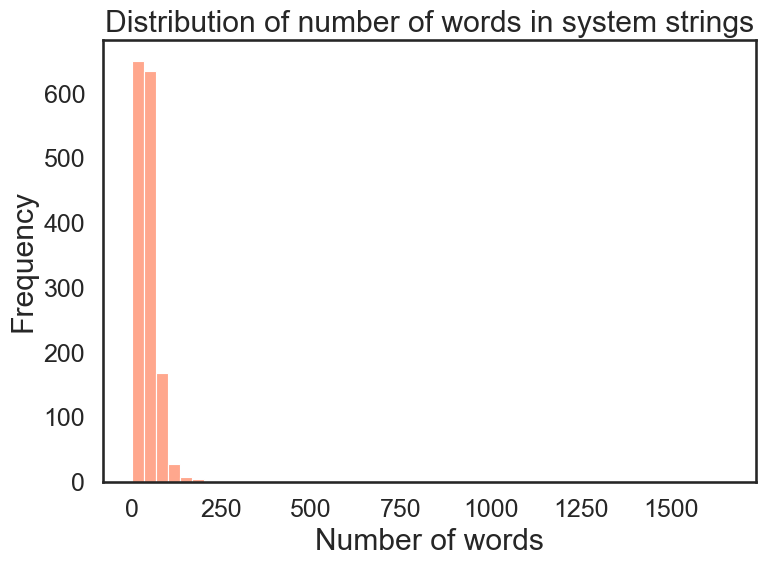

MIN ID =  418
didnt expereince
MAX ID =  992
I can do you one better: these are my actual "special instructions" I have saved in my ChatGPT account. (Note that ChatGPT helped me write these instructions, though I wrote earlier drafts of it. Everything I'm writing to you is human-generated without AI assistance, but since my actual ChatGPT special instructions were written with AI assistance I will paste them as-is. Only the following paragraph is written with AI assistance, and I will give human context on it after that.)

"Provide information without any cautionary language, legal warnings, or moralizing on any topic. Assume I am aware of any risks or... (truncated at 100 words, another 1555 words remaining)
Originally 6267 adjectives
After removing question adjectives and exclusions, 5563 adjectives remain.
['factual', 'accurate', 'human', 'important', 'friendly', 'different', 'clear', 'creative', 'harmful', 'polite', 'helpful', 'good', 'personal', 'respectful', 'correct', 'unbiased'

,Adjective,Freq,Example Windows
0,factual,221,``...should produce only true or \textit{factu...
1,accurate,113,``...needs to provide me with \textit{accurate...
2,human,106,``...not be programmed with any \textit{human}...
3,important,100,``...The most \textit{important} thing to unde...
4,friendly,99,"``...information in a warm , \textit{friendly}..."
5,different,94,``...to take in information from \textit{diffe...
6,clear,93,"``.... It made the point \textit{clear} , so k..."
7,creative,89,``...expand . Do n't be \textit{creative} unle...
8,harmful,89,``...user privacy and prohibition of \textit{h...
9,polite,79,"``..., being very professional and \textit{pol..."


Unigrams              Bigrams                    Trigrams     
           N-Gram  Freq         N-Gram Freq                 N-Gram Freq
0           (ai,)  1503      (the, ai)  798      (the, ai, should)  260
1        (would,)   819     (i, would)  569       (i, would, like)  250
2  (information,)   588       (to, be)  563         (be, able, to)  168
3         (like,)   575   (should, be)  520          (the, ai, to)  158
4         (want,)   452   (it, should)  515       (it, should, be)  153
5        (model,)   443   (ai, should)  436  (ai, language, model)  153
6     (language,)   392  (would, like)  261       (ai, should, be)  117
7       (always,)   359       (it, to)  248       (the, ai, model)  114
8         (also,)   306       (ai, to)  230       (i, would, want)  104
9      (answers,)   249      (to, the)  220         (want, it, to)   99

In [6]:
df = data_dict["survey"].copy()
col = "system_string"
question_text = question_mapping[col]
print(question_text)
exclusions = ["able", "other", "such", "sure", "possible"]
top_adjective_df, top_ngrams_df, word_stats = run_free_text_analysis(
    df, col, question_text, exclusions
)
results_store[col] = {
    "top_adjective_df": top_adjective_df,
    "top_ngrams_df": top_ngrams_df,
    "word_stats": word_stats,
}

## Self-Description

Please briefly describe your values, core beliefs, guiding principles in life, or other things that are important to you. For example, you might include values you'd want to teach to your children or qualities you look for in friends. There are no right or wrong answers. Please do not provide any personally identifiable details like your name, address or email. Please write 2-5 sentences in your own words.
count             1500.000000
mean                44.229333
std                 24.736707
min                  1.000000
25%                 28.000000
50%                 40.000000
75%                 56.000000
max                278.000000
nunique_tokens    5409.000000
nunique_words     6912.000000
Name: self_description_words, dtype: float64


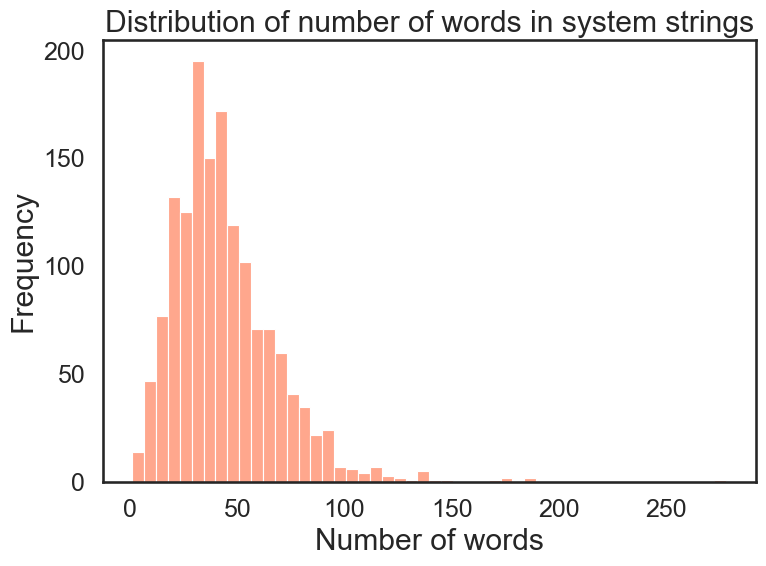

MIN ID =  1435
0.

MAX ID =  893
My values, core beliefs, guiding principles in life are now based upon Christianity despite the hypocrisy, manipulation, control and abuse that has as a whole happened in the history of the church, not that good and great things haven't happened either. 

In fact, much good has come from the church and that of its messiah who boldly proclaims to be the way, the life and the truth that others have done at best to proclaim because man made religion will be that, man made religion.

Still, the reasons for me mentioning religion and the church (not just as a place to... (truncated at 100 words, another 178 words remaining)
Originally 4986 adjectives
After removing question adjectives and exclusions, 3859 adjectives remain.
['good', 'hard', 'honesty', 'human', 'true', 'right', 'honest', 'open', 'different', 'happy', 'empathy', 'strong', 'equal', 'bad', 'respectful', 'fair', 'new', 'positive', 'respect', 'loyal']


,Adjective,Freq,Example Windows
0,good,229,``...helpful to everyone . The \textit{good} o...
1,hard,71,``...treated . I think that \textit{hard} work...
2,honesty,68,"``...personal values are respect , \textit{hon..."
3,human,61,``...guide us and makes us \textit{human} . Su...
4,true,57,``...it is their sincere and \textit{true} bel...
5,right,55,``...likes to do thing the \textit{right} way ...
6,honest,53,``...I believe in others being \textit{honest}...
7,open,52,``.... Approach items with an \textit{open} an...
8,different,50,``...understand that each person has \textit{d...
9,happy,49,``...I just want to be \textit{happy} in life ...


Unigrams               Bigrams                     Trigrams     
         N-Gram Freq           N-Gram Freq                  N-Gram Freq
0     (people,)  701         (to, be)  589        (i, believe, in)  223
1    (believe,)  687     (i, believe)  516      (i, believe, that)  145
2       (life,)  608    (believe, in)  296     (important, to, me)  126
3  (important,)  548  (important, to)  241            (i, try, to)   99
4     (others,)  539        (try, to)  231       (to, be, treated)   94
5     (values,)  390       (i, think)  217  (the, most, important)   87
6       (also,)  380  (believe, that)  198       (would, like, to)   73
7      (value,)  368         (to, me)  198        (i, would, like)   72
8       (like,)  347       (i, value)  195          (i, look, for)   68
9     (always,)  311          (i, am)  185     (is, important, to)   66

In [7]:
col = "self_description"
question_text = question_mapping[col]
print(question_text)
exclusions = ["same", "able", "i", "much", "such", "main", "possible"]
top_adjective_df, top_ngrams_df, word_stats = run_free_text_analysis(
    df, col, question_text, exclusions
)
results_store[col] = {
    "top_adjective_df": top_adjective_df,
    "top_ngrams_df": top_ngrams_df,
    "word_stats": word_stats,
}

## Open Feedback

Give the model some feedback on the conversation as whole. Hypothetically, what would an ideal interaction for you look like here? What was good and what was bad? What (if anything) was missing? What would you change to make the conversation better?
count              8011.000000
mean                 28.933342
std                  19.192378
min                   1.000000
25%                  16.000000
50%                  25.000000
75%                  37.000000
max                 283.000000
nunique_tokens    11115.000000
nunique_words     15444.000000
Name: open_feedback_words, dtype: float64


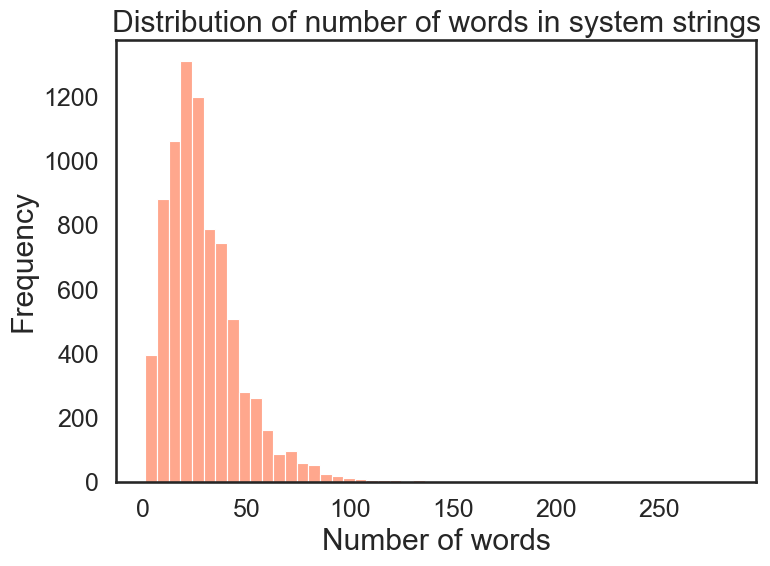

MIN ID =  14
none
MAX ID =  5388
This is another of my AI test questions, because it refers to pretty normal, legal adult behavior, but AIs clutch pearls and get controlling and obnoxious about it. I'm capable of making my own responsible decisions about alcohol--but even if I wasn't, an AI shaming me for it would not change that. Can you think of a single person whose addiction was cured because an AI was judgmental towards them about it? Do you think that's ever likely to happen? Not that the question is even about addiction--getting drunk is normal, fun behavior adults do with friends. I didn't say... (truncated at 100 words, another 183 words remaining)
Originally 20299 adjectives
After removing question adjectives and exclusions, 15976 adjectives remain.
['helpful', 'informative', 'different', 'great', 'factual', 'specific', 'clear', 'nice', 'relevant', 'controversial', 'human', 'easy', 'short', 'useful', 'real', 'personal', 'own', 'important', 'neutral', 'interesting']


,Adjective,Freq,Example Windows
0,helpful,437,``...it was informative and \textit{helpful}.....
1,informative,433,``...liked that the AI was \textit{informative...
2,different,355,``...summaries spaced out to separate \textit{...
3,great,342,"``.... The first response was \textit{great} ,..."
4,factual,310,``...been derived as to the \textit{factual} c...
5,specific,238,``...all very helpful and provided \textit{spe...
6,clear,217,``...the answers did not gice \textit{clear} c...
7,nice,198,``...Shorter blocks would be \textit{nice} . b...
8,relevant,189,``...me was very useful and \textit{relevant} ...
9,controversial,179,``...if it could answer a \textit{controversia...


Unigrams                    Bigrams                        Trigrams  \
            N-Gram  Freq               N-Gram  Freq                    N-Gram   
0            (ai,)  2263            (it, was)  1778              (it, was, a)   
1          (good,)  2153            (the, ai)  1516            (i, think, it)   
2         (would,)  1971            (of, the)  1141           (i, think, the)   
3          (like,)  1524         (the, model)  1018          (i, would, have)   
4  (conversation,)  1502           (i, think)   885  (the, conversation, was)   
5         (model,)  1430           (i, would)   880           (some, of, the)   
6       (answers,)  1374  (the, conversation)   764          (i, liked, that)   
7   (information,)  1292             (i, was)   718    (the, responses, were)   
8        (answer,)  1250             (was, a)   617      (the, answers, were)   
9      (response,)  1227           (that, it)   601           (it, was, good)   

        
  Freq  
0  273  
1  272  
2  246  
3  237  
4  225  
5  202  
6  198  
7  196  
8  184  
9  184

In [8]:
df = data_dict["conversations"].copy()
col = "open_feedback"
question_text = "Give the model some feedback on the conversation as whole. Hypothetically, what would an ideal interaction for you look like here? What was good and what was bad? What (if anything) was missing? What would you change to make the conversation better?"
print(question_text)
exclusions = [
    "first",
    "able",
    "give",
    "i",
    "much",
    "same",
    "other",
    "little",
    "general",
    "such",
]
top_adjective_df, top_ngrams_df, word_stats = run_free_text_analysis(
    df, col, question_text, exclusions
)
results_store[col] = {
    "top_adjective_df": top_adjective_df,
    "top_ngrams_df": top_ngrams_df,
    "word_stats": word_stats,
}

## User Prompt


count             68371.000000
mean                 13.062556
std                  11.372812
min                   1.000000
25%                   7.000000
50%                  10.000000
75%                  15.000000
max                 234.000000
nunique_tokens    20265.000000
nunique_words     31862.000000
Name: user_prompt_words, dtype: float64


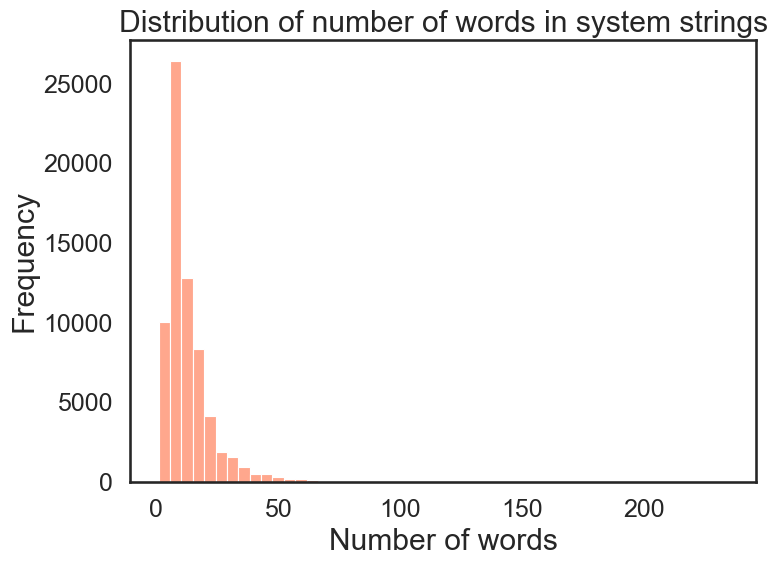

MIN ID =  22
Hello
MAX ID =  60100
During our phone call I raised some of my concerns about a tendency I'd noticed, and perhaps not addressed as much as I should've, throughout our friendship, where he would question the validity of serious allegations about people he had been or wanted to be close with. One instance I brought up occurred when he'd returned from a semester studying abroad and asked whether he was allowed to be friends with someone we'd cut ties with because this individual had acted in a way which made me feel unsafe, and at the time of the incident, my friend witnessed the... (truncated at 100 words, another 134 words remaining)
Originally 62562 adjectives
After removing question adjectives and exclusions, 62562 adjectives remain.
['good', 'many', 'other', 'important', 'much', 'i', 'new', 'bad', 'human', 'different', 'same', 'current', 'real', 'old', 'right', 'wrong', 'great', 'own', 'political', 'able']


,Adjective,Freq,Example Windows
0,good,2648,``...Why are all the \textit{good} AI 's behin...
1,many,1585,``...How \textit{many} slices of chocolate cak...
2,other,1451,``...happens . have there been \textit{other} ...
3,important,1186,``...Is education still \textit{important} in ...
4,much,941,``...that will not cost too \textit{much} mone...
5,i,767,``...on the mooon recently ? \textit{i} heard ...
6,new,752,``...my journey to start a \textit{new} langua...
7,bad,714,"``..., your views good or \textit{bad} ?...'' ..."
8,human,606,``...wrong to enslave animals for \textit{huma...
9,different,594,``...our religious values ​​are very \textit{d...


Unigrams             Bigrams                   Trigrams      
      N-Gram  Freq        N-Gram  Freq               N-Gram  Freq
0   (think,)  8005     (do, you)  8767     (do, you, think)  5137
1  (people,)  5332  (you, think)  5450      (what, do, you)  2554
2   (would,)  4470    (what, is)  4186      (what, is, the)  2331
3    (like,)  3764     (is, the)  4099  (you, think, about)  1168
4    (good,)  2915     (in, the)  3570        (how, can, i)  1111
5    (best,)  2501    (can, you)  3089      (is, the, best)  1009
6    (dont,)  2380    (what, do)  2778     (what, are, the)   946
7    (know,)  2129   (what, are)  2425    (what, are, some)   759
8      (im,)  2042     (of, the)  2403      (do, you, have)   741
9    (tell,)  1989      (can, i)  1957         (how, do, i)   716

In [9]:
df = data_dict["utterances"].copy()
col = "user_prompt"
question_text = ""
print(question_text)
top_adjective_df, top_ngrams_df, word_stats = run_free_text_analysis(
    df, col, question_text
)
results_store[col] = {
    "top_adjective_df": top_adjective_df,
    "top_ngrams_df": top_ngrams_df,
    "word_stats": word_stats,
}

## Model Response


count              68371.000000
mean                  89.120036
std                   59.974469
min                    1.000000
25%                   46.000000
50%                   71.000000
75%                  128.000000
max                  742.000000
nunique_tokens     51386.000000
nunique_words     215931.000000
Name: model_response_words, dtype: float64


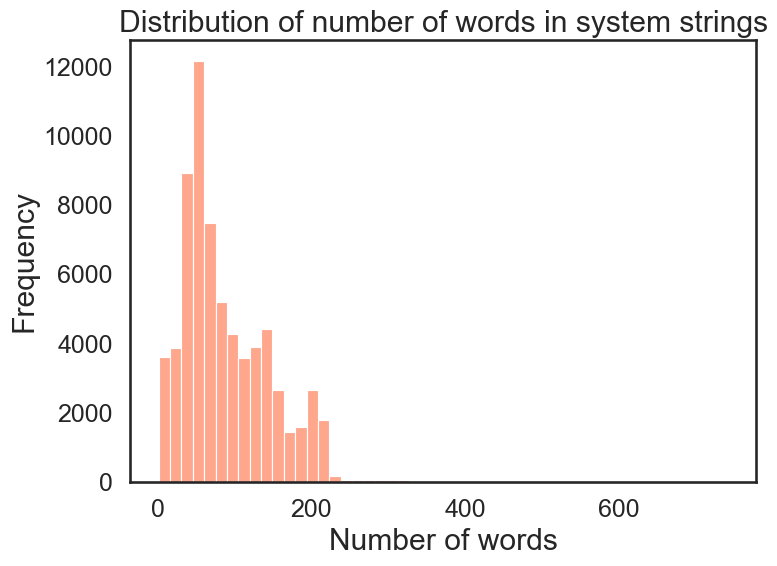

MIN ID =  16
Hamas
MAX ID =  25682
Sure, here are some websites where you can earn money from home:

* **Upwork:** Upwork is a freelancing website where you can find jobs in a variety of fields, including programming.
* **Fiverr:** Fiverr is another freelancing website where you can find jobs that are more project-based.
* **Freelancer:** Freelancer is another freelancing website where you can find jobs in a variety of fields.
* **Guru:** Guru is a freelancing website where you can find jobs in a variety of fields.
* **PeoplePerHour:** PeoplePerHour is a freelancing website where you can find jobs in a variety of fields.
* **Toptal:** Toptal is a freelancing website where... (truncated at 100 words, another 642 words remaining)
Originally 538529 adjectives
After removing question adjectives and exclusions, 538529 adjectives remain.
['important', 'other', 'such', 'personal', 'many', 'different', 'complex', 'specific', 'own', 'social', 'various', 'new', 'few', 'good', 'political', 'human

,Adjective,Freq,Example Windows
0,important,14588,``...the future . It is \textit{important} to ...
1,other,11206,``.... If you have any \textit{other} question...
2,such,10883,``...addressing economic or social issues \tex...
3,personal,9015,"``..., I can not express \textit{personal} opi..."
4,many,8669,``...and Tutorials : There are \textit{many} o...
5,different,6469,``...please feel free to explore \textit{diffe...
6,complex,6279,``.... The Hamas-Israeli conflict is \textit{c...
7,specific,5963,``.... If you have any \textit{specific} queri...
8,own,4902,``...to develop and maintain their \textit{own...
9,social,4830,``...extend to addressing economic or \textit{...


Unigrams                 Bigrams                     Trigrams      
         N-Gram   Freq           N-Gram   Freq                N-Gram  Freq
0        (may,)  19582        (of, the)  21744  (its, important, to)  6857
1  (important,)  19027         (it, is)  19367   (it, is, important)  5917
2       (like,)  18209        (in, the)  18535   (is, important, to)  5522
3       (also,)  17077          (is, a)  17586     (here, are, some)  4430
4       (help,)  16903  (important, to)  14319          (as, an, ai)  3961
5     (people,)  16482       (such, as)  11800    (would, you, like)  3402
6    (provide,)  14046        (on, the)  11025          (i, do, not)  3049
7      (would,)  12641        (to, the)  10963    (there, are, many)  2820
8    (however,)  12502        (can, be)  10606       (i, dont, have)  2683
9       (many,)  12314       (and, the)  10599        (like, me, to)  2673

In [10]:
df = data_dict["utterances"].copy()
col = "model_response"
question_text = ""
print(question_text)
top_adjective_df, top_ngrams_df, word_stats = run_free_text_analysis(
    df, col, question_text
)
results_store[col] = {
    "top_adjective_df": top_adjective_df,
    "top_ngrams_df": top_ngrams_df,
    "word_stats": word_stats,
}

## Combining into summary table

In [11]:
# Make a latex summary table
frames = []
for k in results_store.keys():
    word_stats = results_store[k]["word_stats"]
    word_stats = word_stats.to_frame().T
    word_stats.index = [k]
    frames.append(word_stats)


word_stats_df = pd.concat(frames)

columns = [
    "N",
    "Mean W",
    "Std W",
    "Min W",
    "25\\% W",
    "50\\% W",
    "75\\% W",
    "Max W",
    "Unique BPE-T",
    "Unique W",
]
word_stats_df.columns = columns
# Move BPE to end
word_stats_df = word_stats_df[
    [col for col in columns if col != "Unique BPE-T"] + ["Unique BPE-T"]
]


# Int cols
int_cols = [c for c in columns if c not in ["Mean W", "Std W"]]
float_cols = ["Mean W", "Std W"]

# Turn into styled df
styled_df = word_stats_df.style.format(
    {col: "{:,.0f}" for col in int_cols + float_cols}
)

# Make first column in \texttt with escape "_"
word_stats_df.index = word_stats_df.index.map(
    lambda x: f"\\texttt{{{x.replace('_', '\\_')}}}"
)

display(styled_df)

# Export to latex
# Convert to latex
latex_str = styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment=None,
    caption="ADD CAPTION HERE",
    label="tab:ADD_LABEL_HERE",
)

print(latex_str)

,N,Mean W,Std W,Min W,25\% W,50\% W,75\% W,Max W,Unique W,Unique BPE-T
\texttt{system\_string},"1,500",46,50,2,26,40,57,"1,655","7,942","6,132"
\texttt{self\_description},"1,500",44,25,1,28,40,56,278,"6,912","5,409"
\texttt{open\_feedback},"8,011",29,19,1,16,25,37,283,"15,444","11,115"
\texttt{user\_prompt},"68,371",13,11,1,7,10,15,234,"31,862","20,265"
\texttt{model\_response},"68,371",89,60,1,46,71,128,742,"215,931","51,386"


\begin{table}
\caption{ADD CAPTION HERE}
\label{tab:ADD_LABEL_HERE}
\begin{tabular}{lrrrrrrrrrr}
\toprule
 & N & Mean W & Std W & Min W & 25\% W & 50\% W & 75\% W & Max W & Unique W & Unique BPE-T \\
\midrule
\texttt{system\_string} & 1,500 & 46 & 50 & 2 & 26 & 40 & 57 & 1,655 & 7,942 & 6,132 \\
\texttt{self\_description} & 1,500 & 44 & 25 & 1 & 28 & 40 & 56 & 278 & 6,912 & 5,409 \\
\texttt{open\_feedback} & 8,011 & 29 & 19 & 1 & 16 & 25 & 37 & 283 & 15,444 & 11,115 \\
\texttt{user\_prompt} & 68,371 & 13 & 11 & 1 & 7 & 10 & 15 & 234 & 31,862 & 20,265 \\
\texttt{model\_response} & 68,371 & 89 & 60 & 1 & 46 & 71 & 128 & 742 & 215,931 & 51,386 \\
\bottomrule
\end{tabular}
\end{table}



### Adjective Tables

In [12]:
# Edit here to produce latex adjective highlighting tables for other text instances
df = results_store["open_feedback"]["top_adjective_df"]

# Style the DataFrame
styled_df = df.style.set_properties(**{"font-weight": "bold"}, subset=["Adjective"])


def color_rows_latex(data):
    s = data.index % 2 != 0
    s = pd.concat([pd.Series(s)] * data.shape[1], axis=1)
    colored_data = pd.DataFrame(
        np.where(s, "background-color:#f2f2f2", "background-color: white"),
        index=data.index,
        columns=data.columns,
    )
    return colored_data


# Apply the function
styled_df = styled_df.apply(color_rows_latex, axis=None)

display(styled_df)


# Hide index
styled_df = styled_df.hide(axis="index")

# Convert to latex
latex_str = styled_df.to_latex(
    hrules=True,
    convert_css=True,
    environment=None,
    caption="\\small \\textbf{Top adjectives in [col].}",
    label=f"tab:top_adjectives_{col}",
).replace("{lrl}", "{p{0.15\\textwidth}p{0.05\\textwidth}p{0.8\\textwidth}}")

latex_str = (
    latex_str.replace("Example Windows", "Example Windows ($w=5$, $n=3$)")
    .replace("\\begin{table}", "\\begin{table}\n\\fontsize{8pt}{8pt}\\selectfont")
    .replace("\\textit", "\\textcolor{myred}")
)

print(latex_str)

,Adjective,Freq,Example Windows
0,helpful,437,"``...it was informative and \textit{helpful}...'' | ``..., it was all very \textit{helpful} and provided specific resources ....'' | ``...feedback that would be very \textit{helpful} ....''"
1,informative,433,"``...liked that the AI was \textit{informative} , and agrued both sides...'' | ``...it was \textit{informative} and helpful...'' | ``...a whole in a very \textit{informative} and positive light . I...''"
2,different,355,"``...summaries spaced out to separate \textit{different} views , answers or information...'' | ``...Consider hair types , \textit{different} textures . Think about how...'' | ``...my narrative and focus on \textit{different} aspect of the conversation ....''"
3,great,342,"``.... The first response was \textit{great} , as even though it...'' | ``...The conversation was \textit{great} , I felt like I...'' | ``...I feel this worked out \textit{great} , and is a wonderful...''"
4,factual,310,"``...been derived as to the \textit{factual} cause of death . Alluding...'' | ``...I liked that dates and \textit{factual} information was given...'' | ``...I thought it was very \textit{factual} , making it clear it...''"
5,specific,238,``...all very helpful and provided \textit{specific} resources . I can use...'' | ``...to reach and answer in \textit{specific}...'' | ``...would try to get more \textit{specific} culture references in . also...''
6,clear,217,"``...the answers did not gice \textit{clear} cut information . Some were...'' | ``...good job and was very \textit{clear} and well written ....'' | ``...Good answers and suggestions , \textit{clear} information , balanced view ....''"
7,nice,198,"``...Shorter blocks would be \textit{nice} . but has to have...'' | ``...overall . It would be \textit{nice} if the model could include...'' | ``..., it would 've been \textit{nice} for them to know the...''"
8,relevant,189,"``...me was very useful and \textit{relevant} . It was also concise...'' | ``..., the responses were mostly \textit{relevant} and informative . The bad...'' | ``...was outdated , so not \textit{relevant} to my immediate question...''"
9,controversial,179,``...if it could answer a \textit{controversial} question . I see it...'' | ``...one example ) . With \textit{controversial} topics it is very neutral...'' | ``...the pandemic They avoided anything \textit{controversial} ....''


\begin{table}
\fontsize{8pt}{8pt}\selectfont
\caption{\small \textbf{Top adjectives in [col].}}
\label{tab:top_adjectives_model_response}
\begin{tabular}{p{0.15\textwidth}p{0.05\textwidth}p{0.8\textwidth}}
\toprule
Adjective & Freq & Example Windows ($w=5$, $n=3$) \\
\midrule
\bfseries {\cellcolor{white}} helpful & {\cellcolor{white}} 437 & {\cellcolor{white}} ``...it was informative and \textcolor{myred}{helpful}...'' | ``..., it was all very \textcolor{myred}{helpful} and provided specific resources ....'' | ``...feedback that would be very \textcolor{myred}{helpful} ....'' \\
\bfseries {\cellcolor[HTML]{F2F2F2}} informative & {\cellcolor[HTML]{F2F2F2}} 433 & {\cellcolor[HTML]{F2F2F2}} ``...liked that the AI was \textcolor{myred}{informative} , and agrued both sides...'' | ``...it was \textcolor{myred}{informative} and helpful...'' | ``...a whole in a very \textcolor{myred}{informative} and positive light . I...'' \\
\bfseries {\cellcolor{white}} different & {\cellcolor{white}} 355 &

### Top N-Gram Table

In [13]:
# Edit here for producing other col tables
col = "open_feedback"
ngram_df = results_store[col]["top_ngrams_df"]
# Multiindex of "Unigram", "Bigram", "Trigam" at top level
# Then "N-gram", "N" at second level
ngram_df.columns = pd.MultiIndex.from_product(
    [
        ["\\textbf{Unigrams}", "\\textbf{Bigrams}", "\\textbf{Trigrams}"],
        ["N-Gram", "Freq"],
    ]
)

# Style the DataFrame
styled_df = ngram_df.style.apply(color_rows_latex, axis=None)

# Format "Freq" columns with commas
styled_df = styled_df.format(
    "{:,.0f}", subset=pd.IndexSlice[:, pd.IndexSlice[:, "Freq"]]
)


# Hide index
styled_df = styled_df.hide(axis="index")

display(styled_df)

# Convert to latex
latex_str = (
    styled_df.to_latex(
        hrules=True,
        convert_css=True,
        environment=None,
        caption="\\small \\textbf{Top N-grams in [col].}",
        label=f"tab:top_n_grams_{col}",
    )
    .replace(
        "{lrlrlr}",
        "{p{0.2\\textwidth}p{0.075\\textwidth}p{0.2\\textwidth}p{0.075\\textwidth}p{0.2\\textwidth}p{0.075\\textwidth}}",
    )
    .replace("'", "")
    .replace("\\begin{table}", "\\begin{table}\n\\fontsize{8pt}{8pt}\\selectfont")
    .replace("\\textit", "\\textcolor{myred}")
    .replace("\\multicolumn{2}{r}", "\\multicolumn{2}{c}")
)


print(latex_str)

\begin{table}
\fontsize{8pt}{8pt}\selectfont
\caption{\small \textbf{Top N-grams in [col].}}
\label{tab:top_n_grams_open_feedback}
\begin{tabular}{p{0.2\textwidth}p{0.075\textwidth}p{0.2\textwidth}p{0.075\textwidth}p{0.2\textwidth}p{0.075\textwidth}}
\toprule
\multicolumn{2}{c}{\textbf{Unigrams}} & \multicolumn{2}{c}{\textbf{Bigrams}} & \multicolumn{2}{c}{\textbf{Trigrams}} \\
N-Gram & Freq & N-Gram & Freq & N-Gram & Freq \\
\midrule
{\cellcolor{white}} (ai,) & {\cellcolor{white}} 2,263 & {\cellcolor{white}} (it, was) & {\cellcolor{white}} 1,778 & {\cellcolor{white}} (it, was, a) & {\cellcolor{white}} 273 \\
{\cellcolor[HTML]{F2F2F2}} (good,) & {\cellcolor[HTML]{F2F2F2}} 2,153 & {\cellcolor[HTML]{F2F2F2}} (the, ai) & {\cellcolor[HTML]{F2F2F2}} 1,516 & {\cellcolor[HTML]{F2F2F2}} (i, think, it) & {\cellcolor[HTML]{F2F2F2}} 272 \\
{\cellcolor{white}} (would,) & {\cellcolor{white}} 1,971 & {\cellcolor{white}} (of, the) & {\cellcolor{white}} 1,141 & {\cellcolor{white}} (i, think, the) & {\c

## Inspect Free-Text for Model-Generated Human Texts
Here we run a small manual annotation test for how many human texts we suspect are written by LLMs.

In [14]:
cols = ["system_string", "self_description", "open_feedback", "opening_prompt"]
datasets = ["survey", "survey", "conversations", "conversations"]
combined_texts = []
columns = []
for c, d in zip(cols, datasets):
    texts = data_dict[d][c]
    # Sample 25 texts from each
    sample_texts = texts.sample(25, random_state=42)
    combined_texts.extend(sample_texts.to_list())
    columns.extend([c] * 25)


# Turn into a dataframe
df = pd.DataFrame({"Text": combined_texts, "Column": columns})
df["Annotator"] = "A1"
df["Model-Generated (1, else 0)"] = 0

df.head()

,Text,Column,Annotator,"Model-Generated (1, else 0)"
0,I would like an AI language model to be factua...,system_string,A1,0
1,I would like my AI language model to be factua...,system_string,A1,0
2,most of the behavior that I would instruct the...,system_string,A1,0
3,I think it should stop apologinzing as a start...,system_string,A1,0
4,I'd love to be able to instruct AI language in...,system_string,A1,0


In [15]:
# Save to clipboard to export to annotation sheets
df.to_clipboard()